#  Predicting the Sale Price of Bulldozers using Machine Learning

# 1. Problem defition

How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

# 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

# 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

Note: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

# 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [386]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [387]:
%%time
dataset = pd.read_csv("C:\Buldozer\TrainAndValid.csv", low_memory=False)

Wall time: 11.5 s


In [388]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [389]:
dataset.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [390]:
columns = dataset.columns
columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

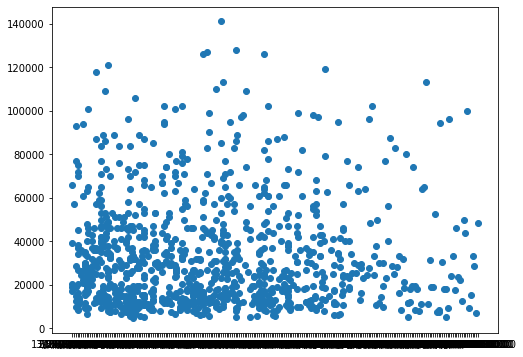

In [391]:
##fig , ax = plt.scatter(df["SalePrice"][:1000],df["saledate"][:1000])
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(dataset["saledate"][:1000],dataset["SalePrice"][:1000]);

In [392]:
dataset.saledate.dtype, dataset["saledate"].head(5), dataset.saledate

(dtype('O'),
 0    11/16/2006 0:00
 1     3/26/2004 0:00
 2     2/26/2004 0:00
 3     5/19/2011 0:00
 4     7/23/2009 0:00
 Name: saledate, dtype: object,
 0         11/16/2006 0:00
 1          3/26/2004 0:00
 2          2/26/2004 0:00
 3          5/19/2011 0:00
 4          7/23/2009 0:00
                ...       
 412693      3/7/2012 0:00
 412694     1/28/2012 0:00
 412695     1/28/2012 0:00
 412696      3/7/2012 0:00
 412697     1/28/2012 0:00
 Name: saledate, Length: 412698, dtype: object)

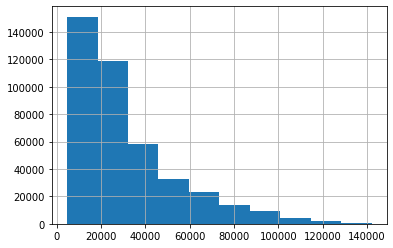

In [393]:
dataset.SalePrice.hist();

# Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.
We can do that by telling pandas which of our columns has dates in it using the parse_dates parameter.

In [394]:
dataset = pd.read_csv("C:\Buldozer\TrainAndValid.csv", low_memory=False, parse_dates= ["saledate"] )
dataset.saledate.dtype, dataset["saledate"].head(5)

(dtype('<M8[ns]'),
 0   2006-11-16
 1   2004-03-26
 2   2004-02-26
 3   2011-05-19
 4   2009-07-23
 Name: saledate, dtype: datetime64[ns])

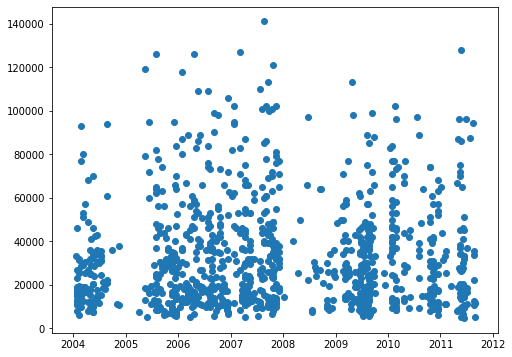

In [395]:
##fig , ax = plt.scatter(df["SalePrice"][:1000],df["saledate"][:1000])
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(dataset["saledate"][:1000],dataset["SalePrice"][:1000]);

In [396]:
##df.columns
##df.head(5)
dataset.head(5).T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [397]:
dataset.values

array([[1139246, 66000.0, 999089, ..., nan, 'Standard', 'Conventional'],
       [1139248, 57000.0, 117657, ..., nan, 'Standard', 'Conventional'],
       [1139249, 10000.0, 434808, ..., nan, nan, nan],
       ...,
       [6333347, 12500.0, 1944213, ..., nan, nan, nan],
       [6333348, 10000.0, 1794518, ..., nan, nan, nan],
       [6333349, 13000.0, 1944743, ..., nan, nan, nan]], dtype=object)

In [398]:
dataset.sort_values(by=["SalesID"]).head(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

Add datetime parameters for saledate column

In [427]:
dataset_tmp = dataset.copy()

In [428]:
dataset_tmp["saleyear"] = dataset_tmp.saledate.dt.year
dataset_tmp["salemonth"] = dataset_tmp.saledate.dt.month
dataset_tmp["saleday"] = dataset_tmp.saledate.dt.day
dataset_tmp["saledayofweek"] = dataset_tmp.saledate.dt.dayofweek
dataset_tmp["saledayofyear"] = dataset_tmp.saledate.dt.dayofyear

dataset_tmp.shape, dataset.shape
## df_tmp now has additional column which are listed above, where as df does not have it

((412698, 58), (412698, 53))

In [429]:
dataset_tmp.drop(["saledate"], axis=1 , inplace=True)
##Dropping the column as we have enriched the dataset

In [430]:
dataset_tmp.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleyear', 'salemonth',
       'saleday', 'saledayofweek', 'saledayofyear'],
      dtype

In [431]:
dataset_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [432]:
from sklearn.ensemble import RandomForestRegressor


X = dataset_tmp.drop(["SalePrice"] , axis =1)
y = dataset_tmp["SalePrice"]

model = RandomForestRegressor( random_state=42 , n_jobs = -1 )

model.fit(X,y)

ValueError: could not convert string to float: 'Low'

In [433]:
dataset_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [434]:
dataset_tmp.notna().sum() /len(dataset_tmp)*100

SalesID                     100.000000
SalePrice                   100.000000
MachineID                   100.000000
ModelID                     100.000000
datasource                  100.000000
auctioneerID                 95.120887
YearMade                    100.000000
MachineHoursCurrentMeter     35.741390
UsageBand                    17.850826
fiModelDesc                 100.000000
fiBaseModel                 100.000000
fiSecondaryDesc              65.900731
fiModelSeries                14.215480
fiModelDescriptor            18.128510
ProductSize                  47.514890
fiProductClassDesc          100.000000
state                       100.000000
ProductGroup                100.000000
ProductGroupDesc            100.000000
Drive_System                 25.948030
Enclosure                    99.919069
Forks                        47.907913
Pad_Type                     19.650204
Ride_Control                 37.007206
Stick                        19.650204
Transmission             

In [435]:
dataset_tmp.isna().sum() /  len(dataset_tmp)*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

# Convert string to categories

One way we can turn all of our data into numbers is by converting them into pandas catgories.
We can check the different datatypes compatible with pandas here: https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality

In [436]:
pd.api.types.is_string_dtype(dataset_tmp["UsageBand"]), pd.api.types.is_string_dtype(dataset_tmp["saleyear"])

(True, False)

In [438]:
for labels, content in dataset_tmp.items():
    if pd.api.types.is_string_dtype(content):
        dataset_tmp[labels] = content.astype("category").cat.as_ordered()
        print(labels)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [439]:
dataset_tmp.info()
##Validating are string fields converted to Category.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [440]:
dataset_tmp.state.cat.codes
dataset_tmp.state.cat.categories


dataset_tmp.Blade_Type.cat.codes
dataset_tmp.Blade_Type.cat.categories


Index(['Angle', 'Coal', 'Landfill', 'No', 'None or Unspecified', 'PAT',
       'Semi U', 'Straight', 'U', 'VPAT'],
      dtype='object')

# Converting null values with meadian values

In [441]:
## Checking what % of data w.r.t  column is null
dataset_tmp.isna().sum() / len(dataset_tmp)*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

In [442]:
## Storing the data in a file after convering string to category.
dataset_tmp.to_csv("C:\Buldozer\TrainAndValid_Category.csv")

In [443]:
##  reading the same file and validating hte count of the records
aa = pd.read_csv("C:\Buldozer\TrainAndValid_Category.csv",low_memory=False)
aa.shape

(412698, 58)

Identifying only numerical columns and updating all the missing values with median values

In [444]:
for label, content in dataset_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum() != 0 :
            dataset_tmp[label+"_is_missing"] = pd.isnull(content)
            dataset_tmp[label] = content.fillna(content.median())
            print(label)
            

auctioneerID
MachineHoursCurrentMeter


In [445]:
dataset_tmp.shape

(412698, 59)

In [446]:
## One way to check is the nuall value filled with median
##dataset_tmp[dataset_tmp["auctioneerID_is_missing"] == True]

##other way to check is the value filled
##dataset_tmp.info()

##other way to check is the value filled
dataset_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

Identifying NON numerical columns and updating all the missing values with median values

In [447]:
x=0

for label, content in dataset_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        dataset_tmp[label+"is_missing"] =  pd.isna(content)
        dataset_tmp[label] = pd.Categorical(content).codes + 1
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [448]:
dataset_tmp.isna().sum()

SalesID                        0
SalePrice                      0
MachineID                      0
ModelID                        0
datasource                     0
                              ..
Backhoe_Mountingis_missing     0
Blade_Typeis_missing           0
Travel_Controlsis_missing      0
Differential_Typeis_missing    0
Steering_Controlsis_missing    0
Length: 103, dtype: int64

In [449]:
dataset_tmp.Blade_Type.value_counts()

0     330823
6      39633
8      13461
5      11841
7       8907
10      3681
9       1888
1       1684
4        743
3         26
2         11
Name: Blade_Type, dtype: int64

In [454]:
dataset_tmp.head(5).T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
...,...,...,...,...,...
Backhoe_Mountingis_missing,True,True,True,True,True
Blade_Typeis_missing,True,True,True,True,True
Travel_Controlsis_missing,True,True,True,True,True
Differential_Typeis_missing,False,False,True,True,True


In [453]:
%%time

model =  RandomForestRegressor( n_jobs= -1,
                               random_state=42
                                )

X = dataset_tmp.drop("SalePrice" , axis =1)
y = dataset_tmp["SalePrice"]

model.fit(X , y )

MemoryError: Unable to allocate 31.5 MiB for an array with shape (10, 412698) and data type int64

In [452]:
model.score(X,y)
## Although this looks like good score, we have tested on the training data itself. so it does not hold water

IndexError: list index out of range

In [304]:
dataset_tmp.head(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Widthis_missing,Stick_Lengthis_missing,Thumbis_missing,Pattern_Changeris_missing,Grouser_Typeis_missing,Backhoe_Mountingis_missing,Blade_Typeis_missing,Travel_Controlsis_missing,Differential_Typeis_missing,Steering_Controlsis_missing
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,2,963,...,True,True,True,True,True,True,True,True,False,False
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,2,1745,...,True,True,True,True,True,True,True,True,False,False
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,1,336,...,True,True,True,True,True,True,True,True,True,True
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,1,3716,...,True,True,True,True,True,True,True,True,True,True
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,3,4261,...,True,True,True,True,True,True,True,True,True,True


In [311]:
dataset_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controlsis_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [337]:
dataset_tmp.saleyear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleyear, dtype: int64

Let us divide the dataset into training and validation data set and creating X & y

In [352]:
ds_train = dataset_tmp[dataset_tmp["saleyear"] != 2012]
ds_valid = dataset_tmp[dataset_tmp["saleyear"] == 2012]

ds_valid.shape, ds_train.shape

((11573, 103), (401125, 103))

In [353]:
X_train = ds_train.drop("SalePrice", axis=1)
y_train = ds_train["SalePrice"]

X_valid = ds_valid.drop("SalePrice", axis=1)
y_valid = ds_valid["SalePrice"]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [351]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test,y_preds))


In [368]:
def show_scores(model):
    
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    scores = {
                "Training MAE" :mean_absolute_error(y_train,train_preds),
                "Validation MAE" : mean_absolute_error(y_valid,valid_preds),

                "Training R2" : r2_score(y_train,train_preds),
                "Validation R2" : r2_score(y_valid,valid_preds),

                "Training rmsle" : rmsle(y_train,train_preds),
                "Validation rmsle" : rmsle(y_valid,valid_preds)
            }
    return scores

# Testing our model on a subset (to tune the hyperparameters)

In [363]:
model = RandomForestRegressor( n_jobs= -1,
                              random_state=42,
                              max_samples= 10000
                                )

In [364]:
%%time
model.fit(X_train,y_train)

Wall time: 18.7 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [366]:
%%time
show_scores(model)

Wall time: 6.05 s


{'Training MAE': 5554.061618822063,
 'Validation MAE': 7139.615822172297,
 'Training R2': 0.8608402371243158,
 'Validation R2': 0.83308596217853,
 'Training rmsle': 0.29248380187626777}

Hyerparameter tuning with RandomizedSearchCV

In [376]:
%%time

from sklearn.model_selection import RandomizedSearchCV

rs_random = {
            "n_estimators" : np.arange(10,100,10),
            "max_depth" : [None,10,15],
            "min_samples_split" : np.arange(2,20,2),
            "min_samples_leaf" :  np.arange(1,20,2),
            "max_features" : [0.5,1,"sqrt","auto"],
            "max_samples" : [10000]}

##below listed is the best param go hence using it to get the result. Overwritting the above statement. it was used to find the best param
rs_random ={'n_estimators': [70],
 'min_samples_split':[ 8],
 'min_samples_leaf': [9],
 'max_samples': [10000],
 'max_features': ['auto'],
 'max_depth': [15]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                                                  param_distributions = rs_random, 
                                                  cv=5,
                                                  verbose=True)

rs_model.fit(X_train,y_train)
show_scores(rs_model)

C:\Jayaprakash\DataScience\Projects\TestProject\env\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


Wall time: 2min 22s


{'Training MAE': 6066.430117556085,
 'Validation MAE': 7613.196858215923,
 'Training R2': 0.8329428775285592,
 'Validation R2': 0.80358126882331,
 'Training rmsle': 0.2759626106634624,
 'Validation rmsle': 0.30527659345157837}

In [373]:
rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 8,
 'min_samples_leaf': 9,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': 15}

In [378]:
%%time

## Creating new RandomForestRegressor model with best param and fit the model
ideal_model = RandomForestRegressor(n_estimators = 70,
 min_samples_split = 8,
 min_samples_leaf = 9,
 max_samples = 10000,
 max_features = 'auto',
 max_depth = 15
                     )
ideal_model.fit(X_train,y_train)

Wall time: 29.1 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=9,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=70, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Compare the RandomizedSearchCV and RandomForestRegressor model values

In [379]:
show_scores(ideal_model)

{'Training MAE': 6069.403882112075,
 'Validation MAE': 7640.253149981063,
 'Training R2': 0.8326492456679259,
 'Validation R2': 0.8024692690020371,
 'Training rmsle': 0.276210710350594,
 'Validation rmsle': 0.30672966856031214}

In [380]:
show_scores(rs_model)

{'Training MAE': 6066.430117556084,
 'Validation MAE': 7613.196858215923,
 'Training R2': 0.8329428775285592,
 'Validation R2': 0.80358126882331,
 'Training rmsle': 0.27596261066346234,
 'Validation rmsle': 0.30527659345157837}

# Make predictions on test data

In [385]:
dataset_test = pd.read_csv("C:\Buldozer\Test.csv",parse_dates=["saledate"], low_memory=False )
##dataset_test.head(5).T
dataset_test.shape

(12457, 52)

In [384]:
X_train.shape

(401125, 102)